![MLU Logo](../data/MLU_Logo.png)

# Assignment 3

## Related Reading
If you want to read more about these concepts, I'll be putting links here for you to find verious resources.
* [Understanding Random Forests](https://arxiv.org/pdf/1407.7502) Sections 4.3 and 4.4.1. *Random Forests and Out-of-bag Errors*
* [Bagging Predictors](https://statistics.berkeley.edu/sites/default/files/tech-reports/421.pdf), the original paper introducing it.
* [Do We Need Hundreds of Classifiers](https://machinelearningmastery.com/use-random-forest-testing-179-classifiers-121-datasets/), a blog post about a paper testing 179 different classification techniques on 121 different datasets, finding random forests the best.

## This Assignment's Goals
We're going to be digging in to random forests, and seeing how they provide extreme improvements in both computational efficiency and generalization errors.

## Random Forests

We're going to spend most of our time working with random forests here today.  Before diving in, let's load in a more realistic dataset: [fashion MNIST](https://github.com/zalandoresearch/fashion-mnist).  These are little 28x28 greyscale images of various items of clothing.  The classes are ```['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']```.

This is a nice little dataset since the problem is fairly difficult even using modern ML techniques, but it is also in the exact same format as the MNIST dataset, so you can drop it in whenever you get bored with classifying digits.  Loading in the version of Keras currently supported in Eider is a bit of a pain, so I've included a snippet below to bring in the data, manipulate it a bit, and draw a few examples.  This takes about 20 seconds.

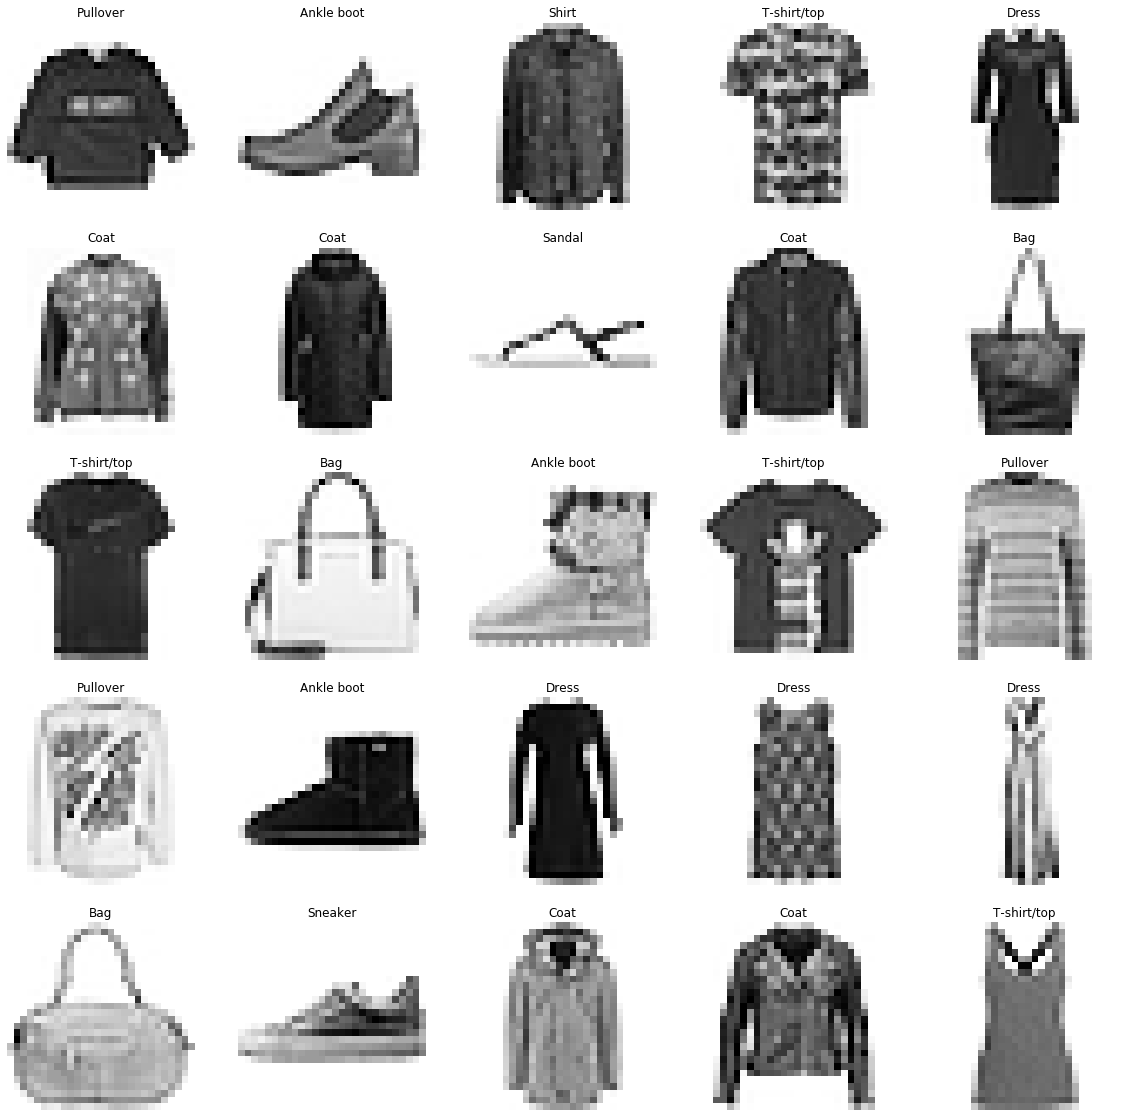

In [1]:
from mxnet import gluon
import numpy as np

# Grab the FashionMNIST dataset
x_train, y_train = gluon.data.vision.FashionMNIST(train=True)[:]
x_test, y_test = gluon.data.vision.FashionMNIST(train=False)[:]

x_train = x_train.asnumpy()
x_test = x_test.asnumpy()

# reshape and scale to be in [0,1]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train /= 255
x_test /= 255

import matplotlib.pyplot as plt

# Plot a handful of examples
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(20,20))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(x_train[i].reshape(28,28),cMap = 'Greys')
    plt.title(classes[y_train[i]])
    plt.axis('off')
plt.show()

We know from class that random forests can both improve the accuracy and computational efficiency, so let's see this at play here.

### Question 1
We will train several [random forest classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) on ```x_train``` and ```y_train``` and monitor their accuracies on ```x_test``` and ```y_test```.  Plot the following four line graph on the same axes.
* The test accuracies for random forest with $1,2,4,8,16,32,$ and $64$ trees in the ensemble with $1$ feature considered per node. 
* The test accuracies for random forest with $1,2,4,8,16,32,$ and $64$ trees in the ensemble with $10$ feature considered per node. 
* The test accuracies for random forest with $1,2,4,8,16,32,$ and $64$ trees in the ensemble with $100$ feature considered per node. 
* (Optional - runs slow) The test accuracies for random forest with $1,2,4,8,16,32,$ and $64$ trees in the ensemble with all feature considered per node (```max_features = None```). 

__*Note*:__ Setting ```n_jobs = -1``` can help accelerate your search by about a factor of four (learning random forests is [embarrasingly parallel](https://en.wikipedia.org/wiki/Embarrassingly_parallel)).  I'd recommend only running the first three until you are done with your code.  The first three graphs are produced in a couple of minutes, the fourth graph boosts the total run-time to about 13 minutes.

What do you observe?

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[P

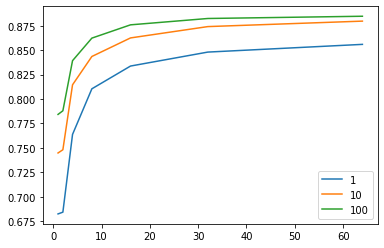

In [2]:
### Answer 1 ###

from sklearn.ensemble import RandomForestClassifier

def plot_growth(n) :
    estimators = [1,2,4,8,16,32,64]
    scores = []
    for n_estimators in estimators:
        clf = RandomForestClassifier(n_estimators = n_estimators,
                                     max_features = n,
                                     n_jobs = -1,
                                     verbose = 1,
                                     random_state = 8675309)
        clf.fit(x_train,y_train)
        scores.append(clf.score(x_test,y_test))
    plt.plot(estimators,scores, label = n)
    
plot_growth(1)
plot_growth(10)
plot_growth(100)
#plot_growth(None) # Slow
plt.legend()

### Answer 1

Indeed, the one using all of the features starts out the strongest, but it quickly tapers off. In fact, in my trials (this is likely dependent on noise) we can see that even a tree using only 10 features outperforms it at an incredibly reduced training cost. 100 features is the stronges performance, but at a cost.

## Computational Efficiency
Assuming all went well above you will have learned two things:
* That picking only 100 features seems to produce the best model amongst those tests, after many trees were averaged
* That training on all features is extremely costly in terms of running time.

Let's dive into this second point.  It is reasonable to say that a good ML model shouldn't just make accurate predicitions, but also should be able to be trained in a fairly short time. [This](https://arxiv.org/pdf/1806.00610.pdf) is a fascinating paper about examining this in the broader context of progress in ML as a whole: to what degree is it really progress if we use $10\times$ the compute resources, to only decrease total error by a handful of percent? Let's see how this trade-off works for random forests.

### Question 2
Train random forests where the ```max_depth```, ```n_estimators```, and ```max_features``` are selected independently at random from the following lists:
```
pos_maxes = np.arange(1,28*28,1)
pos_estimators = np.arange(5,50,1)
pos_depth = np.arange(4,20,1)
```
To keep it efficient, train on only the first $10000$ datapoints (x_train[0:10000], y_train[0:10000]).  Measure both the time it takes to fit (use ```time.time()``` or another timing library of your choice if you desire higer resolution) and the generalization accuracy.  Plot all pairs of scatterplots amongst the three parameters you pick, and the two values you measure ([pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html) is a good tool to remember).  How do your three choices influence the final generalization accuracy?  Make sure you store the data from this section since the code take a while to run (for me about 15 minutes) and we'll be using the information again in the next question.

In [3]:
### Answer 2 ###

import time

pos_maxes = np.arange(1,28*28,1)
pos_estimators = np.arange(5,50,1)
pos_depth = np.arange(4,20,1)

maxes = []
estimators = []
depth = []

times = []
scores = []

for i in range(100) :
    cur_max = np.random.choice(pos_maxes)
    cur_est = np.random.choice(pos_estimators)
    cur_depth = np.random.choice(pos_depth)
    
    clf = RandomForestClassifier(n_estimators = cur_est,
                                 max_features = cur_max,
                                 max_depth = cur_depth,
                                 n_jobs = -1,
                                 random_state = 8675309)
    start = time.time()
    clf.fit(x_train[0:10000],y_train[0:10000])
    end = time.time()
    
    maxes.append(cur_max)
    estimators.append(cur_est)
    depth.append(cur_depth)
    
    times.append(end-start)
    scores.append(clf.score(x_test,y_test))

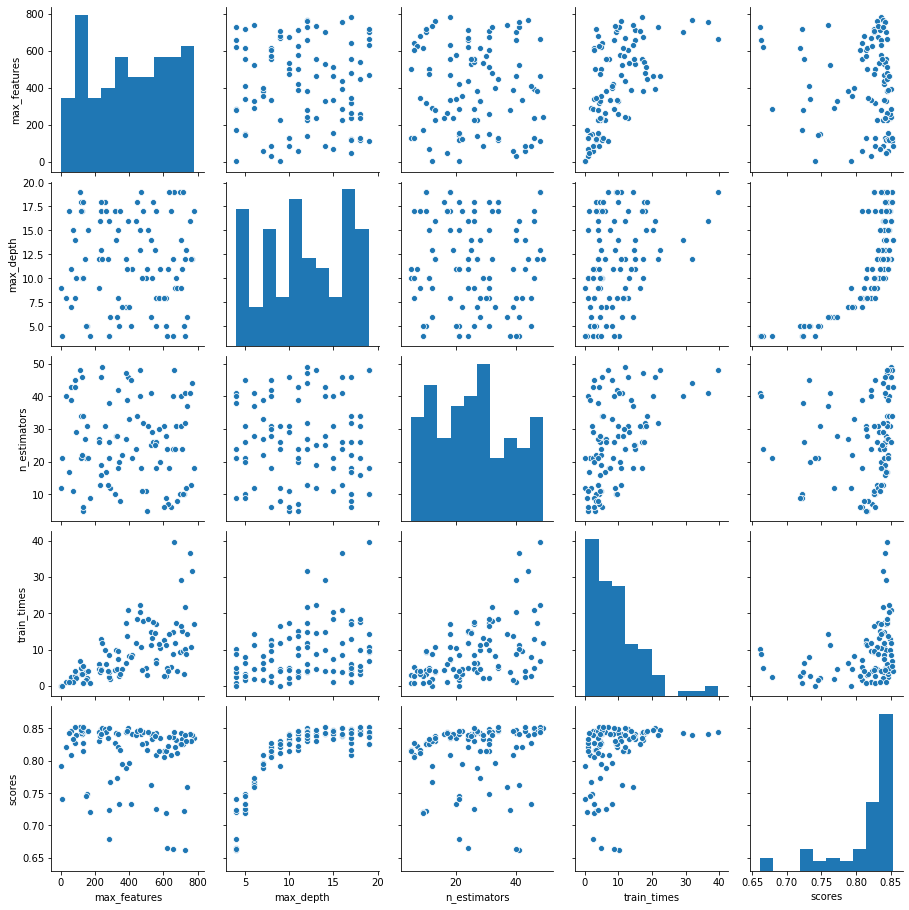

In [4]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame()
df['max_features'] = maxes
df['max_depth'] = depth
df['n_estimators'] = estimators
df['train_times'] = times
df['scores'] = scores

sns.pairplot(df)

### Answer 2

The timings increase essentially linearly with the maximum number of features and number of estimators. This makes sense because we simply need to check that many different features at every split, or train a certain number of trees. In general, the accuracy increases with number of estimators, but peaks at an optimal number of features. Intelligently picking these numbers are key.

Let's keep building on this idea for a little while longer.  

### Question 3
Let's look at our best models, which I'll say are all those models which have accuracy at least $0.84$ on the test data.  You'll see that the parameters and training times are all over the board.  Some models get essentially the same accuracy, but at a cost of massive increase in training times.  What are the parameters of the model that got the absolute best accuracy, versus the one with the shortest training time that still got above $0.84$.  What do you observe?  Which of our hyperparameters is most changed between these two models.

In [5]:
### Answer 3 ###

df2 = df[df['scores'] > 0.84]
print("Best Scoring Model:")
print(df2.loc[df2['scores'].idxmax()])
print()
print("Fastest High Scoring Model:")
print(df2.loc[df2['train_times'].idxmin()])
print()

Best Scoring Model:
max_features    86.00000
max_depth       14.00000
n_estimators    43.00000
train_times      4.13971
scores           0.85300
Name: 82, dtype: float64

Fastest High Scoring Model:
max_features    48.000000
max_depth       17.000000
n_estimators    17.000000
train_times      1.220879
scores           0.842600
Name: 99, dtype: float64



### Answer 3

Training time of best model is 3 times of the fastest one. As you could imagine, if these were hours or days, this would be an enormous cost savings. Max depths are similar but the best performing model uses more features and n_estimators. Note: As we use __np.random.choice()__ functions, you may end up with slightly different results at each run.

## Out-of-bag Scores
The final question we want to address before moving on to the final project section is how you can use out-of-bag errors and how they compare with accuracies on a witheld test set.
### Question 4
We'll again try training many random forests with many possible settings of hyperparameters.  This time, train $100$ random forests with parameters randomly sampled from the ranges
```
pos_maxes = np.arange(1,50,1)
pos_estimators = np.arange(25,35,1)
pos_depth = np.arange(1,20,1)
```
on the first $1000$ data points in ```x_train``` (*note*: this is ten times smaller than the last question).   This time have ```oob_score=True``` set so that it computes the out-of-bag scores.  Store the out-of-bag scores and the scores on ```x_test```.  Scatter plot the two of them to see indeed the two quantities are similar.  If you want to see in greater detail, you can also plot the difference between the out-of-bag scores and the validation scores as a function of the validation score.  

This is great since we do not need to set aside a test/validation set to use the out-of-bag scores.  If you look with a keen eye, you'll see that the out-of-bag score is just a bit more optimistic for the well-fit models than the score from ```x_test```.

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


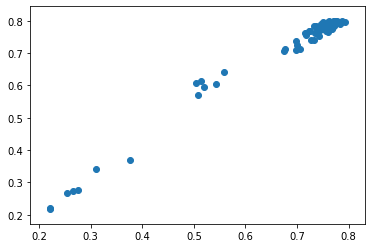

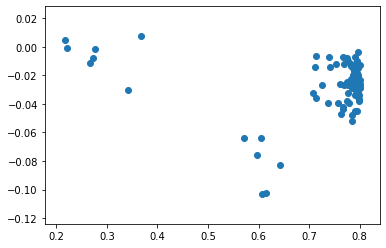

In [6]:
### Answer 4 ###

pos_maxes = np.arange(1,50,1)
pos_estimators = np.arange(25,35,1)
pos_depth = np.arange(1,20,1)

oob = []
cross = []

for i in range(100) :
    print(i)
    cur_max = np.random.choice(pos_maxes)
    cur_est = np.random.choice(pos_estimators)
    cur_depth = np.random.choice(pos_depth)
    
    clf = RandomForestClassifier(n_estimators = cur_est,
                                 max_features = cur_max,
                                 max_depth = cur_depth,
                                 oob_score=True)
    
    clf.fit(x_train[0:1000],y_train[0:1000])

    oob.append(clf.oob_score_)
    cross.append(clf.score(x_test,y_test))
    
plt.scatter(oob,cross)
plt.show()
plt.scatter(cross,np.array(oob)-np.array(cross))
plt.show()

## Final Project Dataset
### Question 5
Now that we have the ideas of random forests in hand, we can start making serious progress much more rapidly, and indeed the ideas you find here may end up being amongst the best performing you get in this class.  Continue working on feature engineering (truely one of the most important components of this project), and apply random forests.  Also feel free to apply bagging classifiers in general, or applying the motivation behind random forests to non tree based methods: if you want to bag tiny neural networks trained on small subsets of the feature space, do it!

In [7]:
### Answer 5 ###

# Write Code Here.